In [50]:
import sys

!{sys.executable} -m pip install -q -q -U pip tqdm scikit-learn pandas sparsesvd plotly pandas matplotlib

# install plotting dependencies
!wget -q https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get -qq install xvfb libgtk2.0-0 libgconf-2-4

In [70]:
import datetime, os, random, shutil, urllib.request, zipfile, time, warnings
warnings.filterwarnings('ignore')
from functools import wraps
from math import trunc
from itertools import product
import numpy as np
import pandas as pd
from pathlib import Path
from urllib.request import urlopen
from zipfile import ZipFile
from scipy.sparse.linalg import norm
import scipy.sparse as ss
from scipy.sparse.linalg import svds
from sparsesvd import sparsesvd
from sklearn.metrics import mean_squared_error as mse
import plotly.express as px
import json
from sys import stdout
import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm import tqdm

SEED = 123
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()

def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

# Preprocessing

In [3]:
def get_dataset():
    path = Path("m1.zip")
    if not path.exists():
        with path.open("wb") as f:
            print("Downloading dataset...")
            f.write(urlopen("http://files.grouplens.org/datasets/movielens/ml-1m.zip").read())
    if not Path("ml-1m").is_dir():
        print("unzipping...")
        with ZipFile("m1.zip") as zf:
            zf.extractall()
    ratings_list = [i.strip().split("::") for i in open('ml-1m/ratings.dat', 'r').readlines()]
    ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
    ratings_df['Rating'] = ratings_df['Rating'].apply(pd.to_numeric)
    return ratings_df

In [4]:
def split(df):
    R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
    seed_everything()
    test_indices = np.array(random.sample(list(np.argwhere(R_df.values>0)), 2500))

    x_indices = test_indices[:,0]
    y_indices = test_indices[:,1]
    u_ids = R_df.index[x_indices].astype(np.int32)
    i_ids = R_df.columns[y_indices].astype(np.int32)
    
    df['UserID'] = df['UserID'].astype(np.int32)
    df['MovieID'] = df['MovieID'].astype(np.int32)
    df['Rating'] = df['Rating'].astype(np.float64)
    
    df= df.drop(columns=['Timestamp'], errors='ignore')
    
    test = []
    for u_id, i_id in zip(u_ids, i_ids):
        test.append(df.loc[(df['UserID'] == u_id) & (df['MovieID'] == i_id)])
    test_df = pd.concat(test)
    train_df= df.drop(test_df.index.tolist())
    
    
    matrix_only_with_test = np.zeros(R_df.shape, dtype=np.float64) 
    matrix_only_with_test[x_indices, y_indices] =  R_df.values[x_indices, y_indices]
    M_test_df = pd.DataFrame(matrix_only_with_test, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    matrix_without_test = R_df.copy().values
    matrix_without_test[x_indices,y_indices] = 0.0
    M_train_df = pd.DataFrame(matrix_without_test, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    return train_df, test_df, M_train_df, M_test_df
    

In [5]:
ratings_df = get_dataset()
train_df, test_df, M_train_df, M_test_df = split(ratings_df)

In [6]:
test_df.head()

,UserID,MovieID,Rating
206405,1265,1732,4.0
409183,2456,2105,3.0
240650,1449,2959,4.0
886005,5350,2640,2.0
540360,3323,3468,4.0


In [7]:
M_train_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




# Funk-SVD

In [9]:
class FunkSVD:
    def __init__(self, lr=.005, reg=.02, n_epochs=20, n_factors=100,
                 min_delta=.001,
                 min_rating=1, max_rating=5):

        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.min_rating = min_rating
        self.max_rating = max_rating

    def fit(self, X, X_test):
        X = self._preprocess_data(X)

        
        X_test = self._preprocess_data(X_test, train=False)
        self._init_metrics()
        self.global_mean_ = np.mean(X[:, 2])
        return self._run_sgd(X, X_test)

    def _preprocess_data(self, X, train=True):
        X = X.copy()
        if train:  # Mappings have to be created
            #assumed that train data includes all possible users and movies (not necessarily ratings)
            user_ids = X['UserID'].unique().tolist()
            item_ids = X['MovieID'].unique().tolist()
            n_users = len(user_ids)
            n_items = len(item_ids)
            user_idx = range(n_users)
            item_idx = range(n_items)
            self.user_mapping_ = dict(zip(user_ids, user_idx))
            self.item_mapping_ = dict(zip(item_ids, item_idx))
        X['UserID'] = X['UserID'].map(self.user_mapping_)
        X['MovieID'] = X['MovieID'].map(self.item_mapping_)
        
        X['UserID'] = X['UserID'].astype(np.int32)
        X['MovieID'] = X['MovieID'].astype(np.int32)
        return X[['UserID', 'MovieID', 'Rating']].values

    def _init_metrics(self):
        metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
        self.metrics_ = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])

    def _run_sgd(self, X, X_test):
        reg,lr,global_mean,n_factors = self.reg,self.lr,self.global_mean_,self.n_factors
        
        n_users = len(np.unique(X[:, 0]))
        n_items = len(np.unique(X[:, 1]))
        bu = np.zeros(n_users)
        bi = np.zeros(n_items)
        pu = np.random.normal(0, .1, (n_users, n_factors))
        qi = np.random.normal(0, .1, (n_items, n_factors))
        
        indices = (X_test[:,0].astype(int), X_test[:,1].astype(int))
        true = X_test[:,2]
        
        # Run SGD
        pbar = tqdm(range(self.n_epochs), desc='Epoch',
                             ncols=110)
        
        #stochastic sgd
        for epoch_ix in pbar:
            
            #with batch size 1
            for row in X:
                user, item, rating = int(row[0]), int(row[1]), row[2]

                pred= np.dot(pu[user,:], qi[item,:])+ global_mean + bu[user]+bi[item]
                err = rating - pred

                # Update biases
                bu[user] += lr * (err - reg * bu[user])
                bi[item] += lr * (err - reg * bi[item])

                # Update latent factors
                pu_update= lr * (err * qi[item, :] - reg * pu[user, :])
                qi_update= lr * (err * pu[user, :] - reg * qi[item, :])
                pu[user, :] = pu[user, :] + pu_update
                qi[item, :] = qi[item, :] + qi_update
            
            #compute test error
            pred = global_mean + np.matmul(pu, qi.T) + bu.reshape(-1, 1) + bi.reshape(1, -1)
            pred = np.clip(pred, self.min_rating, self.max_rating)
            residual = (pred[indices] - true).ravel()
            mse_score = np.square(residual).mean()
            rmse_score = rmse(true, pred[indices])
            mae_score = np.absolute(residual).mean()

            #save results in df
            self.metrics_.loc[epoch_ix, :] = (mse_score, rmse_score, mae_score)
            f = lambda x: f"{self.metrics_.loc[epoch_ix, x]:.3f}"
            pbar.set_postfix({f'test_{m}': f(m) for m in self.metrics_.columns})

        self.bu_,self.bi_,self.pu_,self.qi_ = bu, bi, pu, qi
        return {f"test_{m}": np.trim_zeros(self.metrics_[m]) for m in self.metrics_.columns}

    def predict(self, X):
        return [
            self.predict_pair(u_id, i_id)
            for u_id, i_id in zip(X['UserID'], X['MovieID'])
        ]

    def predict_pair(self, u_id, i_id):
        assert u_id in self.user_mapping_ and i_id in self.item_mapping_, f"user {u_id} or movie {i_id} not in train data"
        
        i_ix = self.item_mapping_[i_id]
        u_ix = self.user_mapping_[u_id]
        pred = self.global_mean_ + self.bi_[i_ix] + self.bu_[u_ix] + np.dot(self.pu_[u_ix], self.qi_[i_ix])
        pred = np.clip(pred, self.min_rating, self.max_rating)
        return pred


In [64]:
class SVT:
    def __init__(self, tau, delta, n_epochs, min_rating=1, max_rating=5):
        self.tau = tau
        self.delta = delta
        self.n_epochs = n_epochs
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.tol = 0.001
        self.increment = 5
    
    def _init_metrics(self):
        metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
        self.metrics_ = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])
    
    def fit(self, M, M_test):
        ### preprocessing -->
        
        self._init_metrics()
        M = M.copy()
        M_test = M_test.copy()
        
        self.user_mapping_ = dict(zip(M.index, range(len(M.index))))
        self.item_mapping_ = dict(zip(M.columns, range(len(M.columns))))
        self.users_mean = np.mean(M.values, axis = 1).reshape(-1, 1)
        
        M = M.values
        M_test= M_test.values
        
        
        Omega = M.astype(np.int32).nonzero()
        test_indices= M_test.astype(np.int32).nonzero()
        
        M = M- self.users_mean
        M_test= M_test - self.users_mean
        
        test_true = M_test[test_indices].ravel()
        
        tol = self.tol
        incre = self.increment
        tau = self.tau
        iterations= self.n_epochs
        delta = self.delta
        ### --> preprocessing

        # SVT
        r = 0
        P_Omega_M = ss.csr_matrix((np.ravel(M[Omega]), Omega), shape=M.shape)
        normProjM = norm(P_Omega_M)
        k0 = np.ceil(tau / (delta * normProjM))
        Y = k0 * delta * P_Omega_M

        pbar = tqdm(range(iterations))

        for epoch_ix in pbar:
            s = r + 1
            sparse_Y = ss.csc_matrix(Y)
            
            #find s largest eigen values. keep increasing s until the s'th largest value is smaller than tau
            u1, s1, v1 = sparsesvd(sparse_Y, s)
            while np.min(s1) > tau and s >= min(*M.shape):
                u1, s1, v1 = sparsesvd(sparse_Y, s)
                s+=incre
                if s>90: 
                    break
            
            if s>90: 
                print(f'number of singular values requested was {s}. this takes too much time!')
                break
            
            #reconstruct x from svd decomposition
            r = np.sum(s1 > tau)
            U = u1.T[:, :r]
            V = v1[:r, :]
            S = s1[:r] - tau
            x = (U * S).dot(V)

            x_omega = ss.csr_matrix((x[Omega], Omega), shape=M.shape)
            
            #if there is no reconstruction error, stop
            if norm(x_omega - P_Omega_M) / norm(P_Omega_M) < tol:
                break
            
            #update Y with values from constructed matrix
            diff = P_Omega_M - x_omega
            Y += delta * diff
                
            #compute test error
            
            M_pred = np.clip((x + self.users_mean), self.min_rating, self.max_rating)-self.users_mean
            test_pred = M_pred[test_indices].ravel()
            
            residual = (test_pred - test_true).ravel()
            mse_score = np.square(residual).mean()
            rmse_score = rmse(test_true, test_pred)
            mae_score = np.absolute(residual).mean()

            #save results in df
            self.metrics_.loc[epoch_ix, :] = (mse_score, rmse_score, mae_score)
            f = lambda x: f"{self.metrics_.loc[epoch_ix, x]:.3f}"
            pbar.set_postfix({f'test_{m}': f(m) for m in self.metrics_.columns})
                
        self.x = x + self.users_mean
        return {f"test_{m}": np.trim_zeros(self.metrics_[m].tolist()) for m in self.metrics_.columns}
    
    
    def predict(self, X):
        return [self.predict_pair(u_id, i_id) for u_id, i_id in zip(X['UserID'], X['MovieID'])]

    def predict_pair(self, u_id, i_id):
        assert u_id in self.user_mapping_ and i_id in self.item_mapping_, f"user {u_id} or movie {i_id} not in train data"
        
        i_ix = self.item_mapping_[i_id]
        u_ix = self.user_mapping_[u_id]
        
        pred= self.x[u_ix,i_ix]
        pred = np.clip(pred, self.min_rating, self.max_rating)
        return pred

## Ensemble Model
#### A simple model averaging two given MF models.

In [11]:
class Ensemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        return [self.predict_pair(u_id, i_id) for u_id, i_id in zip(X['UserID'], X['MovieID'])]
    
    def predict_pair(self, u_id, i_id):
        return sum([m.predict_pair(u_id, i_id) for m in self.models]) / len(self.models)

## Experimental Setup

In [15]:
def to_sparse(df):
    users =[]
    movies =[]
    ratings =[]
    indices = df.values.astype(np.int32).nonzero()
    x_indices,y_indices = indices[0],indices[1]
    
    for i,j in zip(x_indices,y_indices):
        users.append(df.index[i])
        movies.append(df.columns[j])
        ratings.append(df.iloc[i,j])
    
    df = pd.DataFrame(dict(zip(['UserID', 'MovieID', 'Rating'], [users, movies, ratings])))
    return df

def run_funk(train, test, **kw):
    seed_everything()
    svd = FunkSVD(**kw)
    hist = svd.fit(X=train, X_test=test)
    y_true, y_pred = test['Rating'].values.ravel(), np.array(svd.predict(test)).ravel()
    score = rmse(y_true, y_pred)
    best_epoch = np.argmin(hist['test_RMSE'])
    score = hist['test_RMSE'].iloc[best_epoch]
    return hist, svd, score, best_epoch
    
def run_svt(train, test, **kw):
    seed_everything()
    model = SVT(**kw)
    hist = model.fit(M=train, M_test=test)
    
    sparse_test = to_sparse(test)
    y_true, y_pred = sparse_test['Rating'].values.ravel(), np.array(model.predict(sparse_test)).ravel()
    
    print(f"\n\nTest RMSE: {rmse(y_true, y_pred):.3f}\n\n")
    print_hparams(kw, 'SVT')
    return hist, model

def print_hparams(h, name):
    print("Hyperparameters:\n")
    print(f"hist = {name}(train_df, test_df,\n\t" + ", ".join([f"{k}={h[k]}" for k in h]) + ')')
    
def plot_experiment(hist):
    fig = px.line(pd.DataFrame(hist).rename_axis('Epoch'))\
        .update_layout(hoverlabel=dict(font_size=12, font_family="Rockwell"),
                       font=dict(family="Courier New, monospace", size=18))\
        .update_xaxes(showspikes=True)
    fig.show()
    fig.show("svg")

## SVT Grid Search

In [25]:
taus= [20000, 10000, 30000]
deltas=[1, 2, 5, 7]

hists = []
for tau, delta in product(taus,deltas):
    print(f"tau: {tau}, delta: {delta}\n")
    try:
        hist,model = run_svt(train=M_train_df, test=M_test_df,
                tau=tau,
                delta=delta,
                n_epochs=int(500 / delta),
                )
    except Exception as e:
        print('encountered a problem {}. happens when SVT diverges'.format(e))
        continue
    hists.append({'tau':tau, 'delta':delta, 'hist': hist})
    with open('results.json', 'w') as f:
        json.dump(hists, f)

tau: 20000, delta: 1
100%|██████████| 50/50 [00:23<00:00,  2.15it/s, test_Loss=2.044, test_RMSE=1.430, test_MAE=1.115]


Test RMSE: 1.430


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=1, n_epochs=50)
tau: 20000, delta: 2
100%|██████████| 25/25 [00:12<00:00,  2.05it/s, test_Loss=2.101, test_RMSE=1.450, test_MAE=1.135]


Test RMSE: 1.450


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=2, n_epochs=25)
tau: 20000, delta: 5
100%|██████████| 10/10 [00:05<00:00,  1.86it/s, test_Loss=1.950, test_RMSE=1.396, test_MAE=1.077]


Test RMSE: 1.396


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=5, n_epochs=10)
tau: 20000, delta: 7
100%|██████████| 7/7 [00:03<00:00,  1.87it/s, test_Loss=2.154, test_RMSE=1.468, test_MAE=1.144]


Test RMSE: 1.468


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=7, n_epochs=7)
tau: 10000, delta: 1
100%|██████████| 50/50 [00:28<00:00,  1.78it/s, test_Loss=1.515, test_RMSE=1.231, test_MAE=0.9

### SVT Analysis

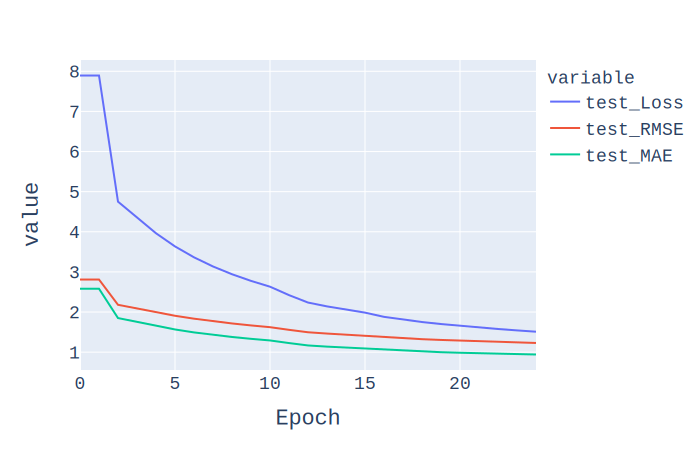

taus,10000,20000,30000
deltas,,,
1,1.2310,1.2286,1.2848
2,2.1385,1.4296,1.4496
5,1.3963,1.4675,1.5786
7,1.5757,1.5938,2.3523


In [65]:
with open('results.json') as f:
    hists = json.load(f)

best = min(hists, key= lambda x: min(x.get('hist',{}).get('test_RMSE', [float('inf')])))
svt_best_tau = best['tau']
svt_best_delta = best['delta']
svt_best_n_epochs = np.argmin(best['hist']['test_RMSE'])
best_hist = best['hist']
plot_experiment(best_hist)

taus = np.unique([hist['tau'] for hist in hists])
deltas = np.unique([hist['delta'] for hist in hists])
rmses = []
for tau, delta in product(taus,deltas):
    rmse = [hist.get('hist',{}).get('test_RMSE', [np.nan])[-1] \
            for hist in hists if hist['tau']==tau and hist['delta']==delta]
    if rmse:
        rmses.append(rmse[0])
    else:
        rmses.append(np.nan)
rmses = np.array(rmses).reshape(len(deltas), len(taus))
df = pd.DataFrame(rmses,index=deltas,columns=taus )

df.index.name = 'deltas'
df.columns.name = 'taus'


def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    s = M-s
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df.style.apply(background_gradient,
               cmap='PuBu',
               m=df.min().min(),
               M=df.max().max(),
               low=0,
               high=0.2).format("{:.4f}")

## Funk-SVD Grid Search

In [74]:
funk_best_score = 999.0
funk_best_lr, funk_best_reg, funk_best_n_factors, funk_best_n_epochs = None, None, None, None

lr_list = np.linspace(0.005, 0.02, 4)
print(f"lr_list: {lr_list}")
reg_list = np.linspace(0.02, 0.04, 3)
print(f"reg_list: {reg_list}")
n_epochs_list = [35] #range(3, 31, 5)
n_factors_list = range(9, 12)
print(f"n_factors_list: {list(n_factors_list)}")
grid_space = list(product(lr_list, reg_list, n_epochs_list, n_factors_list))

pbar = tqdm(grid_space, position=0, leave=True)
open('log.txt', 'w')
open('log_best.txt', 'w')
for lr, reg, n_epochs, n_factors in pbar:
    with open('log.txt', 'a+') as f:
        hp = f"lr: {lr}    reg: {reg}    n_epochs: {n_epochs}    n_factors: {n_factors}\n"
        f.write(hp)
        _, _, score, best_epoch = run_funk(train=train_df, test=test_df, lr=lr, reg=reg,
                               n_epochs=n_epochs, n_factors=n_factors)
        score_str = f"RMSE: {score}\n" + "=" * 60 + "\n\n"
        if score < funk_best_score:
            funk_best_score = score
            funk_best_lr, funk_best_reg, funk_best_n_factors, funk_best_n_epochs = \
                lr, reg, n_factors, best_epoch
            
            new = f"~~~~~~~~~~NEW BEST at EPOCH {best_epoch + 1}~~~~~~~~~~\n"
            f.write(new)
            with open('log_best.txt', 'a+') as f_best:
                f_best.write(hp)
                f_best.write(new)
                f_best.write(score_str)
        f.write(score_str)

Epoch:   0%|                                                                            | 0/2 [00:00<?, ?it/s]

lr_list: [0.005 0.01  0.015 0.02 ]
reg_list: [0.02 0.03 0.04]
n_factors_list: [9, 10, 11]



100%|██████████| 1/1 [00:34<00:00, 34.93s/it]


## TODO: PLOT BEST FUNK

## Run Ensemble

In [76]:
print(f"Running SVT with best found parameters...")
hist, model1 = run_svt(train=M_train_df, test=M_test_df,
                tau=svt_best_tau,
                delta=svt_best_delta,
                n_epochs=svt_best_n_epochs,
                )

print(f"Running Funk-SVD with best found parameters...")
hist, model2, *_ = run_funk(train=train_df, test=test_df,
		lr=funk_best_lr,
		reg=funk_best_reg,
		n_epochs=funk_best_n_epochs,
		n_factors=funk_best_n_factors)

Epoch: 100%|██████████████████| 1/1 [00:16<00:00, 16.87s/it, test_Loss=0.864, test_RMSE=0.929, test_MAE=0.741]


Running svt with 


100%|██████████| 24/24 [00:12<00:00,  1.89it/s, test_Loss=1.542, test_RMSE=1.242, test_MAE=0.951]




Test RMSE: 1.242


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=10000, delta=2, n_epochs=24)


In [ ]:
## TODO: 
## --Consistent printing
## --json dump funk hist

In [77]:
ensemble = Ensemble(models=[model1, model2])

model1_test_pred = model1.predict(test_df)
model2_test_pred = model2.predict(test_df)

ensemble_test_pred = ensemble.predict(test_df)
test_true = test_df['Rating'].values.ravel()

print(f"Test RMSE with SVT: {rmse(model1_test_pred,test_true):.3f}")
print(f"Test RMSE with FunkSVD: {rmse(model2_test_pred,test_true):.3f}")
print(f"Test RMSE with Ensemble: {rmse(ensemble_test_pred,test_true):.3f}")

Test RMSE with SVT: 1.242
Test RMSE with FunkSVD: 0.929
Test RMSE with Ensemble: 0.994
